# Laboratorio 6

Integrantes:  
Andres de la Roca  

Jun Woo Lee

## 1. Preparacion de los datos

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [52]:
# Parametros
n_images = 5000
batch_size = 64
latent_dim = 100
n_epoch = 100
img_shape = (32, 32, 3)

In [53]:
data_dir = '../input/celeba-dataset/img_align_celeba/img_align_celeba/' 
data_dir = 'CelebA/img_align_celeba/img_align_celeba/'
images = os.listdir(data_dir)
images = images[:n_images]

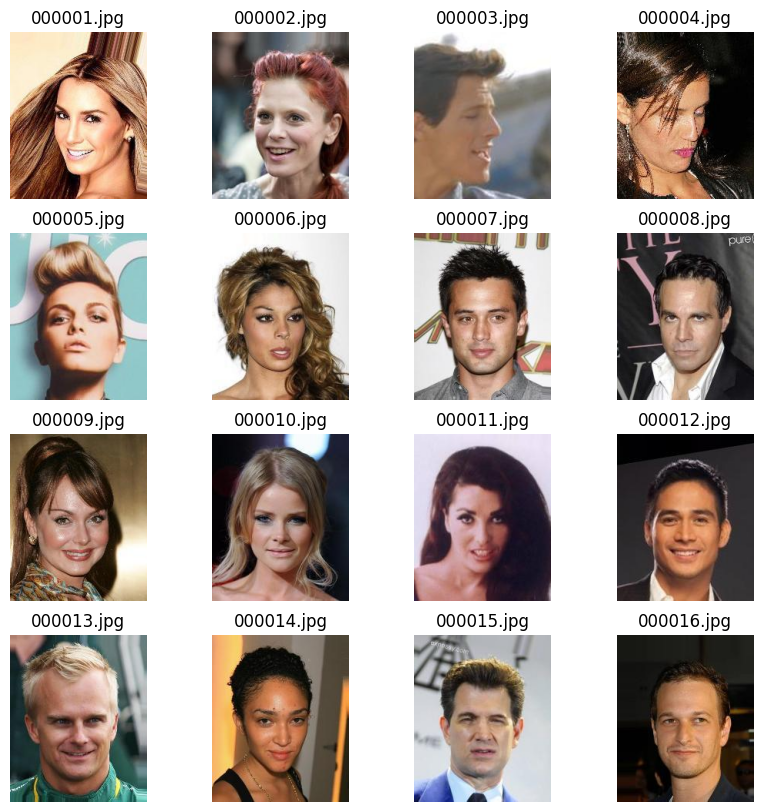

In [54]:
# Mostrar imagenes
plt.figure(figsize=(10,10))
for i, name in enumerate(images[:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

In [55]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    X = X / 255
    return X

dataset = get_data(images)

## 2. Implementacion de la GAN

### Discriminador

In [56]:
# Discriminador
def define_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Generador

In [57]:
# Generator
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

### GAN

In [58]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def get_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

def show_generated(generated,epoch, n=5):

    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated[i])
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = get_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    show_generated(x_fake, epoch)  

## 3. Entrenamiento de la GAN

In [59]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=5, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    start = time.time()
    for i in range(n_epochs):
        
        for j in range(bat_per_epo):
            X_real, y_real = get_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))

1/1 [==============================] - 0s 94ms/step
Epoch: 1,  Loss: D_real = 0.608, D_fake = 0.701,  G = 0.865
1/1 [==============================] - 0s 102ms/step
Epoch: 2,  Loss: D_real = 0.605, D_fake = 0.696,  G = 1.007
1/1 [==============================] - 0s 97ms/step
Epoch: 3,  Loss: D_real = 0.638, D_fake = 0.689,  G = 0.756
1/1 [==============================] - 0s 98ms/step
Epoch: 4,  Loss: D_real = 0.610, D_fake = 0.682,  G = 0.756
1/1 [==============================] - 0s 99ms/step
Epoch: 5,  Loss: D_real = 0.720, D_fake = 0.650,  G = 0.810
1/1 [==============================] - 0s 98ms/step
Epoch: 6,  Loss: D_real = 0.626, D_fake = 0.673,  G = 0.812
1/1 [==============================] - 0s 99ms/step
Epoch: 7,  Loss: D_real = 0.667, D_fake = 0.691,  G = 0.767
1/1 [==============================] - 0s 103ms/step
Epoch: 8,  Loss: D_real = 0.699, D_fake = 0.633,  G = 0.824
1/1 [==============================] - 0s 96ms/step
Epoch: 9,  Loss: D_real = 0.709, D_fake = 0.620,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

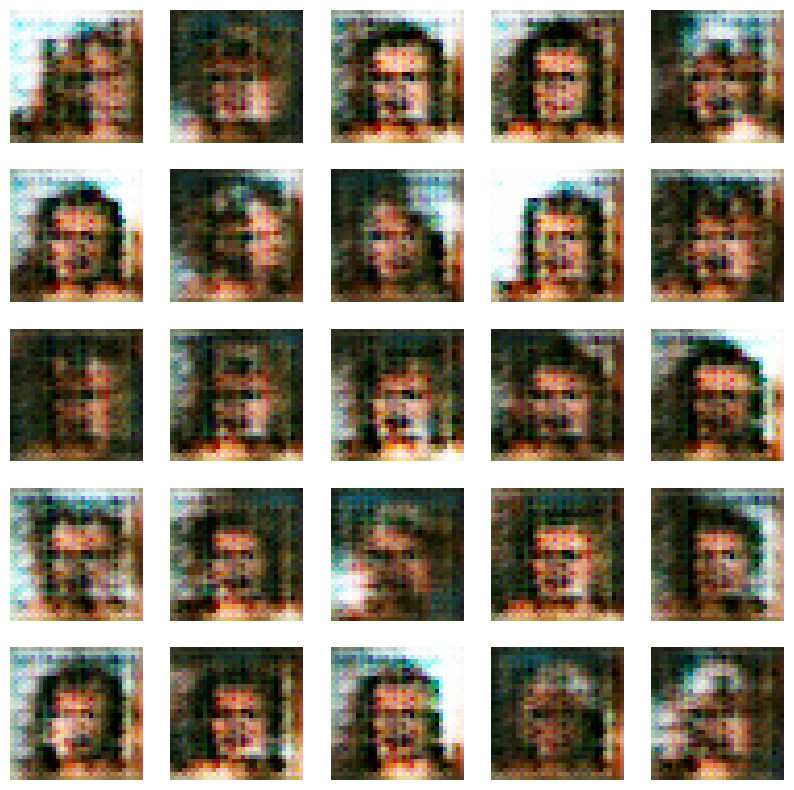

1/1 [==============================] - 0s 96ms/step
Epoch: 11,  Loss: D_real = 0.679, D_fake = 0.722,  G = 0.757
1/1 [==============================] - 0s 91ms/step
Epoch: 12,  Loss: D_real = 0.611, D_fake = 0.725,  G = 0.794
1/1 [==============================] - 0s 92ms/step
Epoch: 13,  Loss: D_real = 0.666, D_fake = 0.695,  G = 0.877
1/1 [==============================] - 0s 90ms/step
Epoch: 14,  Loss: D_real = 0.611, D_fake = 0.658,  G = 0.807
1/1 [==============================] - 0s 86ms/step
Epoch: 15,  Loss: D_real = 0.549, D_fake = 0.715,  G = 0.861
1/1 [==============================] - 0s 91ms/step
Epoch: 16,  Loss: D_real = 0.745, D_fake = 0.626,  G = 0.869
1/1 [==============================] - 0s 90ms/step
Epoch: 17,  Loss: D_real = 0.666, D_fake = 0.649,  G = 0.898
1/1 [==============================] - 0s 85ms/step
Epoch: 18,  Loss: D_real = 0.678, D_fake = 0.602,  G = 0.997
1/1 [==============================] - 0s 92ms/step
Epoch: 19,  Loss: D_real = 0.685, D_fake = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 64%, fake: 97%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

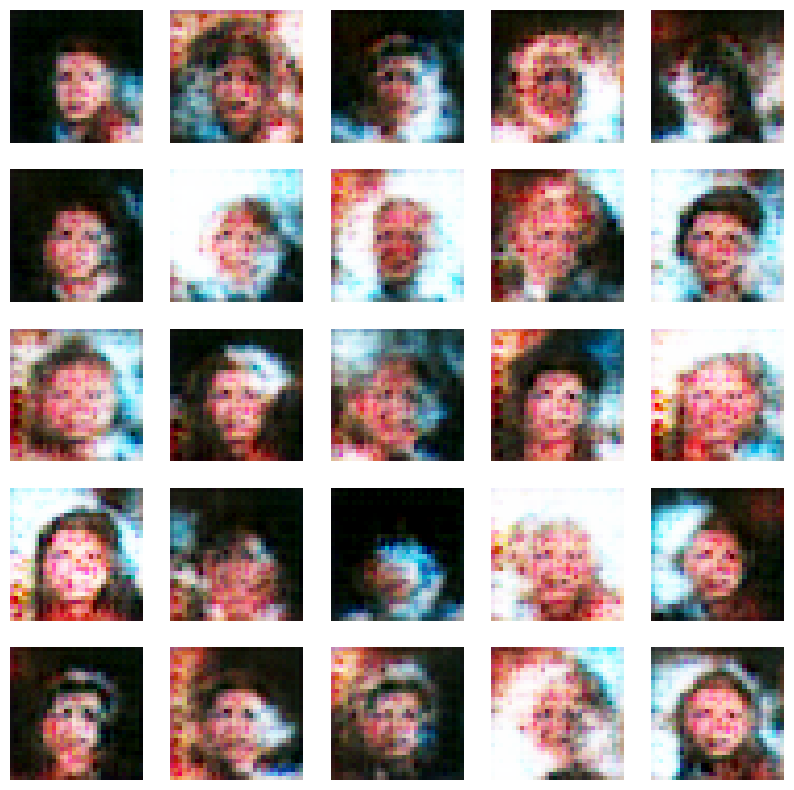

1/1 [==============================] - 0s 98ms/step
Epoch: 21,  Loss: D_real = 0.686, D_fake = 0.626,  G = 0.917
1/1 [==============================] - 0s 100ms/step
Epoch: 22,  Loss: D_real = 0.693, D_fake = 0.631,  G = 0.917
1/1 [==============================] - 0s 89ms/step
Epoch: 23,  Loss: D_real = 0.602, D_fake = 0.580,  G = 0.991
1/1 [==============================] - 0s 95ms/step
Epoch: 24,  Loss: D_real = 0.635, D_fake = 0.700,  G = 1.058
1/1 [==============================] - 0s 95ms/step
Epoch: 25,  Loss: D_real = 0.623, D_fake = 0.616,  G = 0.926
1/1 [==============================] - 0s 95ms/step
Epoch: 26,  Loss: D_real = 0.519, D_fake = 0.666,  G = 0.899
1/1 [==============================] - 0s 94ms/step
Epoch: 27,  Loss: D_real = 0.557, D_fake = 0.673,  G = 0.922
1/1 [==============================] - 0s 94ms/step
Epoch: 28,  Loss: D_real = 0.705, D_fake = 0.614,  G = 0.922
1/1 [==============================] - 0s 94ms/step
Epoch: 29,  Loss: D_real = 0.626, D_fake = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 45%, fake: 92%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

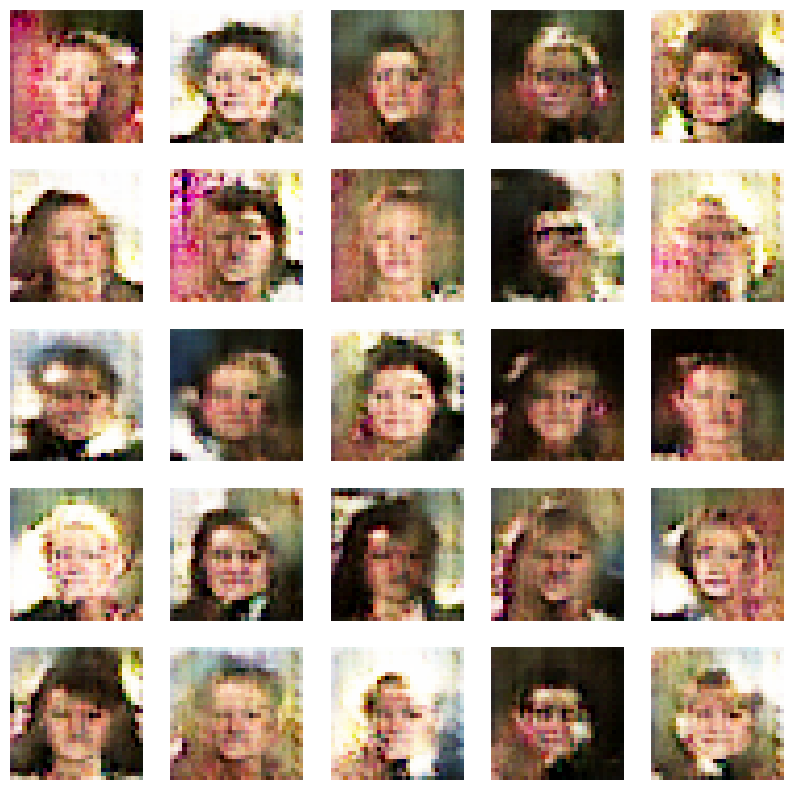

1/1 [==============================] - 0s 95ms/step
Epoch: 31,  Loss: D_real = 0.618, D_fake = 0.628,  G = 1.031
1/1 [==============================] - 0s 95ms/step
Epoch: 32,  Loss: D_real = 0.605, D_fake = 0.652,  G = 0.894
1/1 [==============================] - 0s 97ms/step
Epoch: 33,  Loss: D_real = 0.609, D_fake = 0.622,  G = 0.978
1/1 [==============================] - 0s 94ms/step
Epoch: 34,  Loss: D_real = 0.644, D_fake = 0.642,  G = 0.959
1/1 [==============================] - 0s 90ms/step
Epoch: 35,  Loss: D_real = 0.703, D_fake = 0.633,  G = 0.997
1/1 [==============================] - 0s 83ms/step
Epoch: 36,  Loss: D_real = 0.695, D_fake = 0.693,  G = 0.948
1/1 [==============================] - 0s 93ms/step
Epoch: 37,  Loss: D_real = 0.613, D_fake = 0.627,  G = 1.021
1/1 [==============================] - 0s 83ms/step
Epoch: 38,  Loss: D_real = 0.776, D_fake = 0.616,  G = 0.916
1/1 [==============================] - 0s 95ms/step
Epoch: 39,  Loss: D_real = 0.596, D_fake = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 57%, fake: 90%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

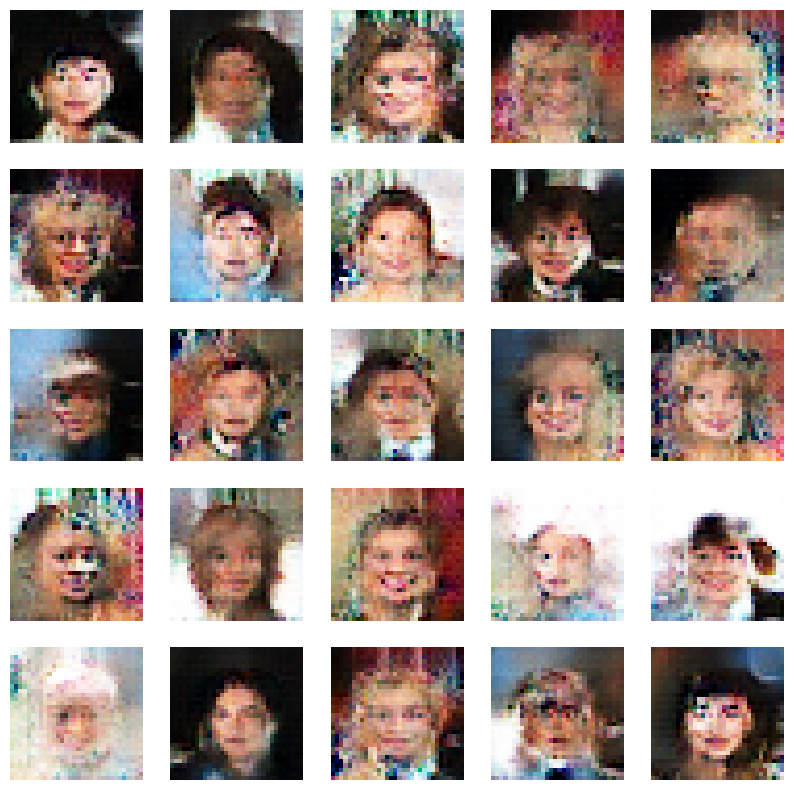

1/1 [==============================] - 0s 91ms/step
Epoch: 41,  Loss: D_real = 0.656, D_fake = 0.635,  G = 0.994
1/1 [==============================] - 0s 85ms/step
Epoch: 42,  Loss: D_real = 0.620, D_fake = 0.616,  G = 0.880
1/1 [==============================] - 0s 93ms/step
Epoch: 43,  Loss: D_real = 0.586, D_fake = 0.711,  G = 0.964
1/1 [==============================] - 0s 84ms/step
Epoch: 44,  Loss: D_real = 0.775, D_fake = 0.555,  G = 0.936
1/1 [==============================] - 0s 87ms/step
Epoch: 45,  Loss: D_real = 0.600, D_fake = 0.630,  G = 0.993
1/1 [==============================] - 0s 90ms/step
Epoch: 46,  Loss: D_real = 0.625, D_fake = 0.551,  G = 0.962
1/1 [==============================] - 0s 85ms/step
Epoch: 47,  Loss: D_real = 0.641, D_fake = 0.598,  G = 0.896
1/1 [==============================] - 0s 97ms/step
Epoch: 48,  Loss: D_real = 0.648, D_fake = 0.623,  G = 0.833
1/1 [==============================] - 0s 85ms/step
Epoch: 49,  Loss: D_real = 0.671, D_fake = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

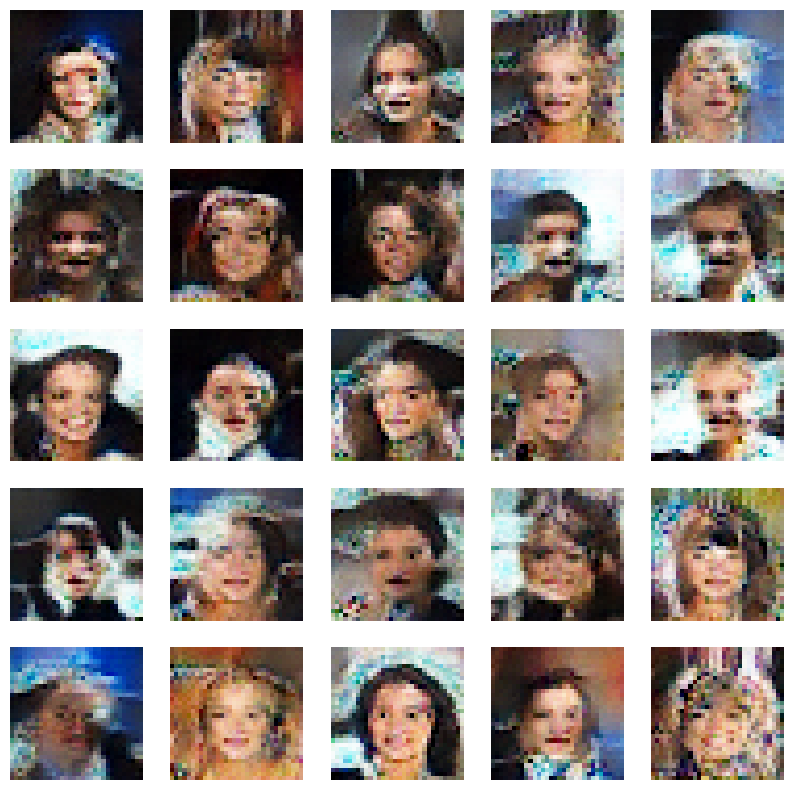

1/1 [==============================] - 0s 95ms/step
Epoch: 51,  Loss: D_real = 0.683, D_fake = 0.561,  G = 0.930
1/1 [==============================] - 0s 94ms/step
Epoch: 52,  Loss: D_real = 0.620, D_fake = 0.537,  G = 0.986
1/1 [==============================] - 0s 91ms/step
Epoch: 53,  Loss: D_real = 0.613, D_fake = 0.656,  G = 0.870
1/1 [==============================] - 0s 91ms/step
Epoch: 54,  Loss: D_real = 0.638, D_fake = 0.613,  G = 0.912
1/1 [==============================] - 0s 91ms/step
Epoch: 55,  Loss: D_real = 0.679, D_fake = 0.539,  G = 0.996
1/1 [==============================] - 0s 89ms/step
Epoch: 56,  Loss: D_real = 0.647, D_fake = 0.621,  G = 0.892
1/1 [==============================] - 0s 87ms/step
Epoch: 57,  Loss: D_real = 0.668, D_fake = 0.609,  G = 0.903
1/1 [==============================] - 0s 166ms/step
Epoch: 58,  Loss: D_real = 0.706, D_fake = 0.705,  G = 0.964
1/1 [==============================] - 0s 95ms/step
Epoch: 59,  Loss: D_real = 0.688, D_fake = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 50%, fake: 96%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

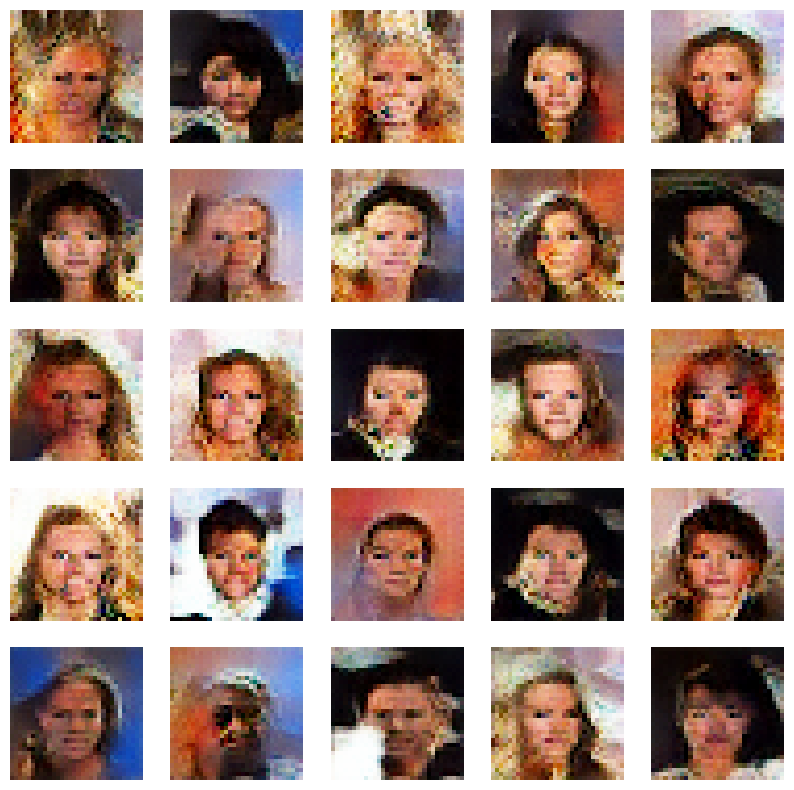

1/1 [==============================] - 0s 93ms/step
Epoch: 61,  Loss: D_real = 0.621, D_fake = 0.642,  G = 0.999
1/1 [==============================] - 0s 91ms/step
Epoch: 62,  Loss: D_real = 0.653, D_fake = 0.653,  G = 0.928
1/1 [==============================] - 0s 102ms/step
Epoch: 63,  Loss: D_real = 0.644, D_fake = 0.634,  G = 0.916
1/1 [==============================] - 0s 102ms/step
Epoch: 64,  Loss: D_real = 0.658, D_fake = 0.543,  G = 0.911
1/1 [==============================] - 0s 141ms/step
Epoch: 65,  Loss: D_real = 0.678, D_fake = 0.616,  G = 0.949
1/1 [==============================] - 0s 101ms/step
Epoch: 66,  Loss: D_real = 0.670, D_fake = 0.578,  G = 0.963
1/1 [==============================] - 0s 99ms/step
Epoch: 67,  Loss: D_real = 0.633, D_fake = 0.604,  G = 1.013
1/1 [==============================] - 0s 101ms/step
Epoch: 68,  Loss: D_real = 0.753, D_fake = 0.490,  G = 1.063
1/1 [==============================] - 0s 99ms/step
Epoch: 69,  Loss: D_real = 0.572, D_fak

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 47%, fake: 87%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

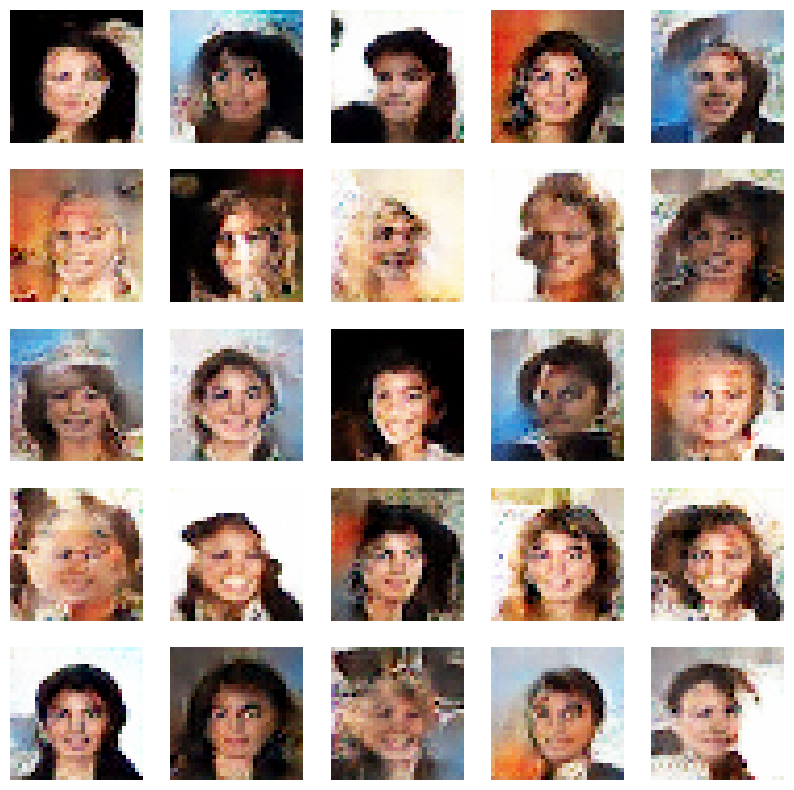

1/1 [==============================] - 0s 385ms/step
Epoch: 71,  Loss: D_real = 0.756, D_fake = 0.600,  G = 1.028
1/1 [==============================] - 0s 144ms/step
Epoch: 72,  Loss: D_real = 0.568, D_fake = 0.585,  G = 1.003
1/1 [==============================] - 0s 140ms/step
Epoch: 73,  Loss: D_real = 0.535, D_fake = 0.704,  G = 1.062
1/1 [==============================] - 0s 154ms/step
Epoch: 74,  Loss: D_real = 0.772, D_fake = 0.568,  G = 0.960
1/1 [==============================] - 0s 173ms/step
Epoch: 75,  Loss: D_real = 0.726, D_fake = 0.627,  G = 1.040
1/1 [==============================] - 0s 255ms/step
Epoch: 76,  Loss: D_real = 0.544, D_fake = 0.607,  G = 1.069
1/1 [==============================] - 0s 186ms/step
Epoch: 77,  Loss: D_real = 0.579, D_fake = 0.719,  G = 0.973
1/1 [==============================] - 0s 96ms/step
Epoch: 78,  Loss: D_real = 0.686, D_fake = 0.561,  G = 0.979
1/1 [==============================] - 0s 94ms/step
Epoch: 79,  Loss: D_real = 0.605, D_f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 58%, fake: 88%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

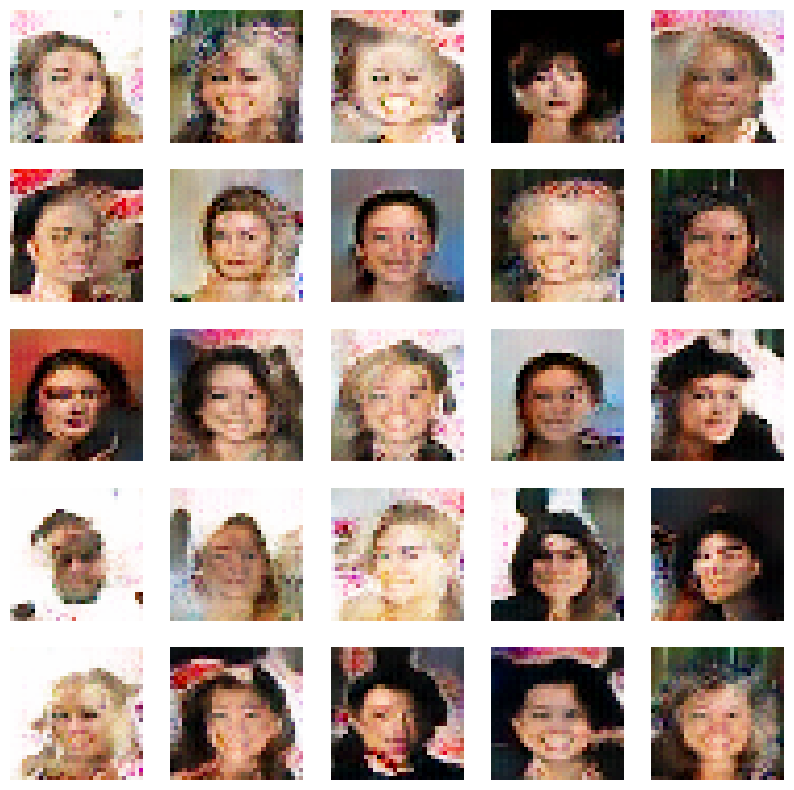

1/1 [==============================] - 0s 97ms/step
Epoch: 81,  Loss: D_real = 0.608, D_fake = 0.619,  G = 0.952
1/1 [==============================] - 0s 93ms/step
Epoch: 82,  Loss: D_real = 0.668, D_fake = 0.514,  G = 1.104
1/1 [==============================] - 0s 101ms/step
Epoch: 83,  Loss: D_real = 0.742, D_fake = 0.570,  G = 1.033
1/1 [==============================] - 0s 93ms/step
Epoch: 84,  Loss: D_real = 0.657, D_fake = 0.672,  G = 1.078
1/1 [==============================] - 0s 107ms/step
Epoch: 85,  Loss: D_real = 0.695, D_fake = 0.597,  G = 1.091
1/1 [==============================] - 0s 96ms/step
Epoch: 86,  Loss: D_real = 0.777, D_fake = 0.576,  G = 0.886
1/1 [==============================] - 0s 99ms/step
Epoch: 87,  Loss: D_real = 0.597, D_fake = 0.549,  G = 1.073
1/1 [==============================] - 0s 99ms/step
Epoch: 88,  Loss: D_real = 0.758, D_fake = 0.445,  G = 1.155
1/1 [==============================] - 0s 91ms/step
Epoch: 89,  Loss: D_real = 0.528, D_fake =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 72%, fake: 88%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

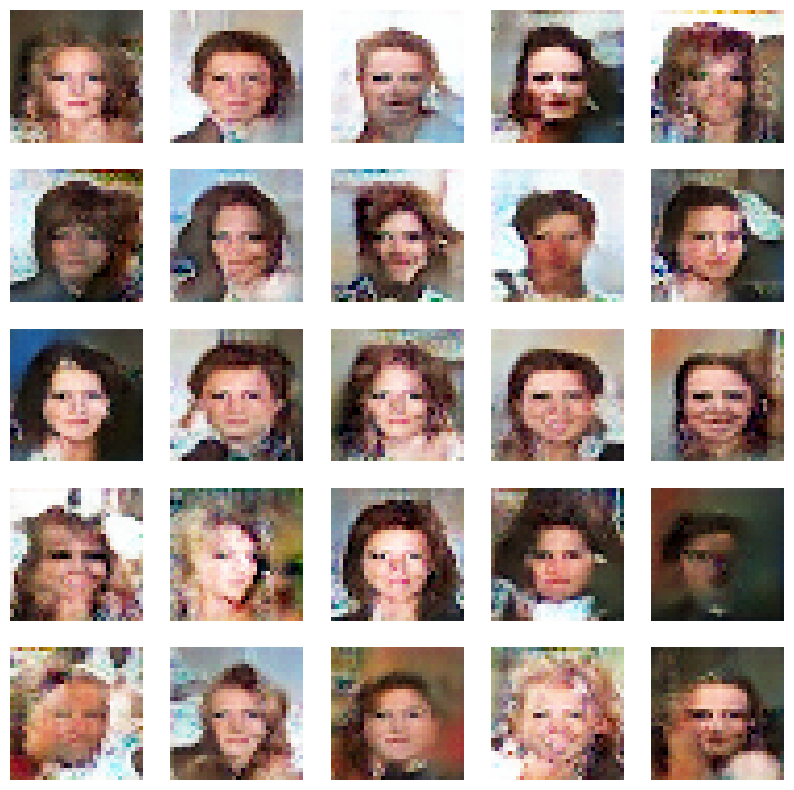

1/1 [==============================] - 0s 103ms/step
Epoch: 91,  Loss: D_real = 0.575, D_fake = 0.625,  G = 0.859
1/1 [==============================] - 0s 96ms/step
Epoch: 92,  Loss: D_real = 0.589, D_fake = 0.591,  G = 0.975
1/1 [==============================] - 0s 96ms/step
Epoch: 93,  Loss: D_real = 0.473, D_fake = 0.609,  G = 1.076
1/1 [==============================] - 0s 95ms/step
Epoch: 94,  Loss: D_real = 0.571, D_fake = 0.798,  G = 1.103
1/1 [==============================] - 0s 281ms/step
Epoch: 95,  Loss: D_real = 0.537, D_fake = 0.504,  G = 1.061
1/1 [==============================] - 0s 176ms/step
Epoch: 96,  Loss: D_real = 0.524, D_fake = 0.663,  G = 0.983
1/1 [==============================] - 0s 196ms/step
Epoch: 97,  Loss: D_real = 0.521, D_fake = 0.592,  G = 1.186
1/1 [==============================] - 0s 211ms/step
Epoch: 98,  Loss: D_real = 0.768, D_fake = 0.553,  G = 0.989
1/1 [==============================] - 0s 168ms/step
Epoch: 99,  Loss: D_real = 0.441, D_fa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 60%, fake: 97%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

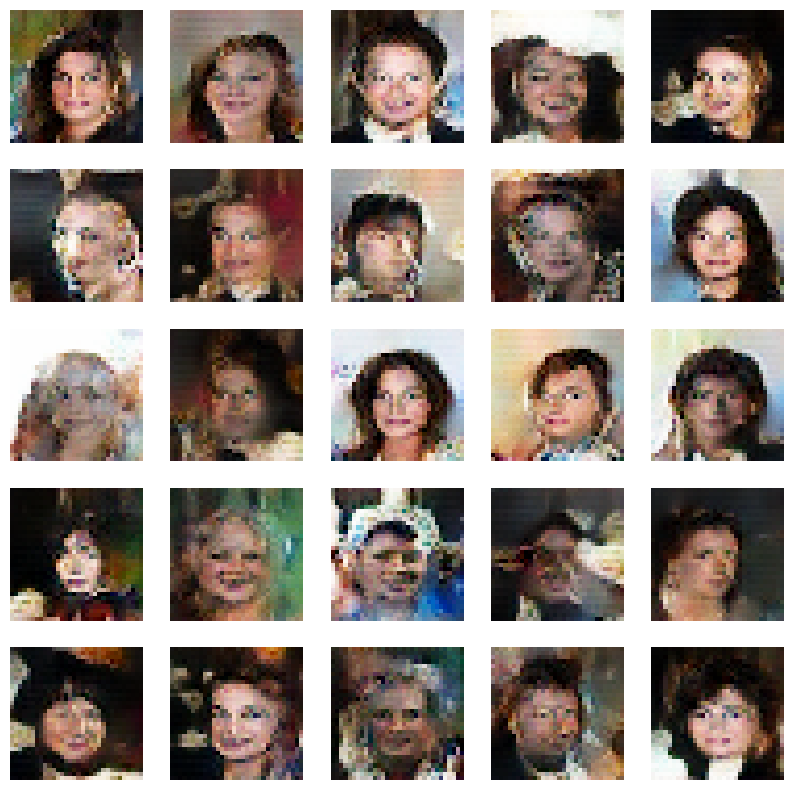

Total time for training 100 epochs is 6974.478006362915 sec


In [60]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

gan = define_gan(generator, discriminator)

train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)


In [61]:
# Create GIF
import glob
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\Andre\AppData\Local\Temp\ipykernel_19240\2264912540.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Andre\AppData\Local\Temp\ipykernel_19240\2264912540.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## 4. Reflexion sobre la sesion teorica y el laboratorio